In [1]:
import os
import sys
import json
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from itertools import combinations
from scipy.stats import shapiro, f_oneway, kruskal
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.multicomp import MultiComparison

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))

from functions.plotting import plot_bars, plot_bar_from_dict

WIDTH = 150
HEIGHT = 150

In [2]:
data_dir = os.path.join(
    '..',
    '..',
    '..',
    'data1',
    'images_original_inception_resnet_v2_150x150_categorized')
test_data_dir = os.path.join(data_dir, 'validation')
test_ds = keras.utils.image_dataset_from_directory(
    directory=test_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(HEIGHT, WIDTH))

Found 2000 files belonging to 7 classes.


In [3]:
ROOT_NAME = 'inception_dealing_with_imbalance_using'
models_dir = os.path.join(
    '..',
    '..',
    'models',
    'data1')
model_names = os.listdir(models_dir)
models = \
    list(
        filter(
            lambda model_file_name: ROOT_NAME in model_file_name,
            model_names))

In [4]:
def get_accuracies_and_losses(models: list[str]) -> (dict[str, float], dict[str, float]):
    accuracies = {}
    losses = {}

    for model_name in models:
        model_path = os.path.join(models_dir, model_name)
        model = keras.models.load_model(model_path)
        loss, _, _, accuracy, _, _ = model.evaluate(test_ds)
        accuracies[model_name] = accuracy
        losses[model_name] = loss

    return accuracies, losses

In [9]:
accuracies_file = os.path.join('..', '..', 'histories', f'{ROOT_NAME}_accuracies.json')
losses_file = os.path.join('..', '..', 'histories', f'{ROOT_NAME}_losses.json')

In [6]:
if not os.path.exists(accuracies_file):
    accuracies, losses = get_accuracies_and_losses(models)

    with open(accuracies_file, 'w') as json_file:
        json.dump(accuracies, json_file, indent=4)
    with open(losses_file, 'w') as json_file:
        json.dump(losses, json_file, indent=4)

63/63 [==============================] - 11s 83ms/step - loss: 0.5400 - categorical cross entropy: 0.5400 - mean squared error: 0.0378 - accuracy: 0.8095 - auc: 0.9340 - prc: 0.7232


In [10]:
with open(accuracies_file, 'r') as accuracies_file_handle:
    accuracies = json.load(accuracies_file_handle)
with open(losses_file, 'r') as losses_file_handle:
    losses = json.load(losses_file_handle)

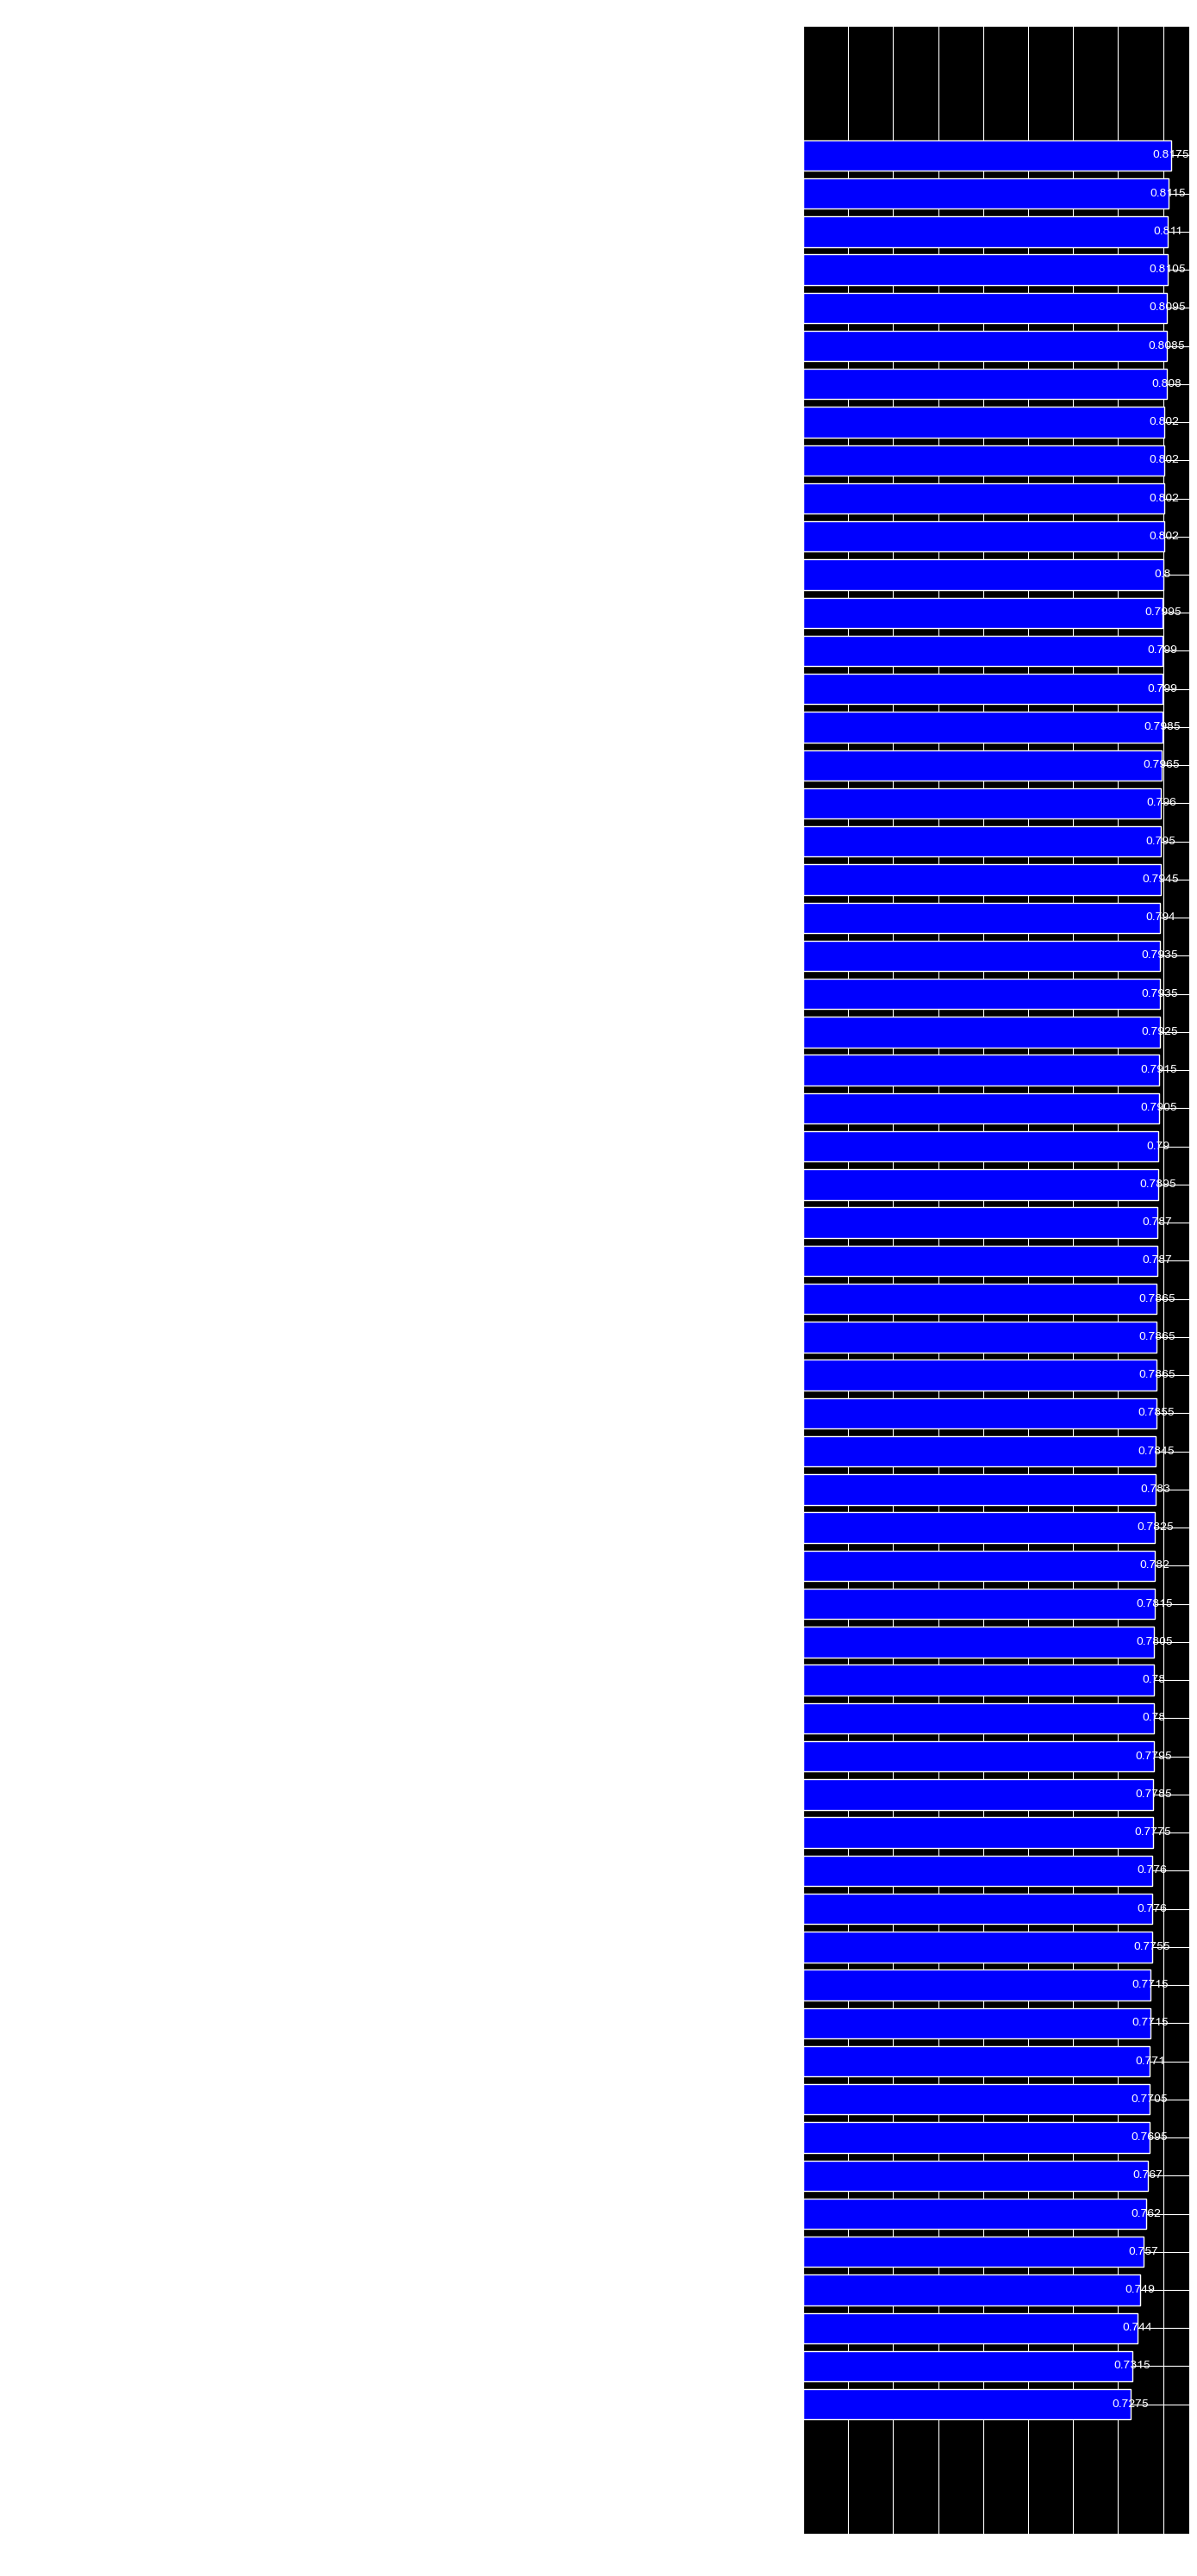

In [11]:
root = os.path.join('..', '..', 'plots', 'testing')
accuracies_pdf_path = os.path.join(root, f'{ROOT_NAME}_accuracies.pdf')

plot_bar_from_dict(accuracies, 'Model Accuracies', 'Name', 'Accuracy', accuracies_pdf_path)

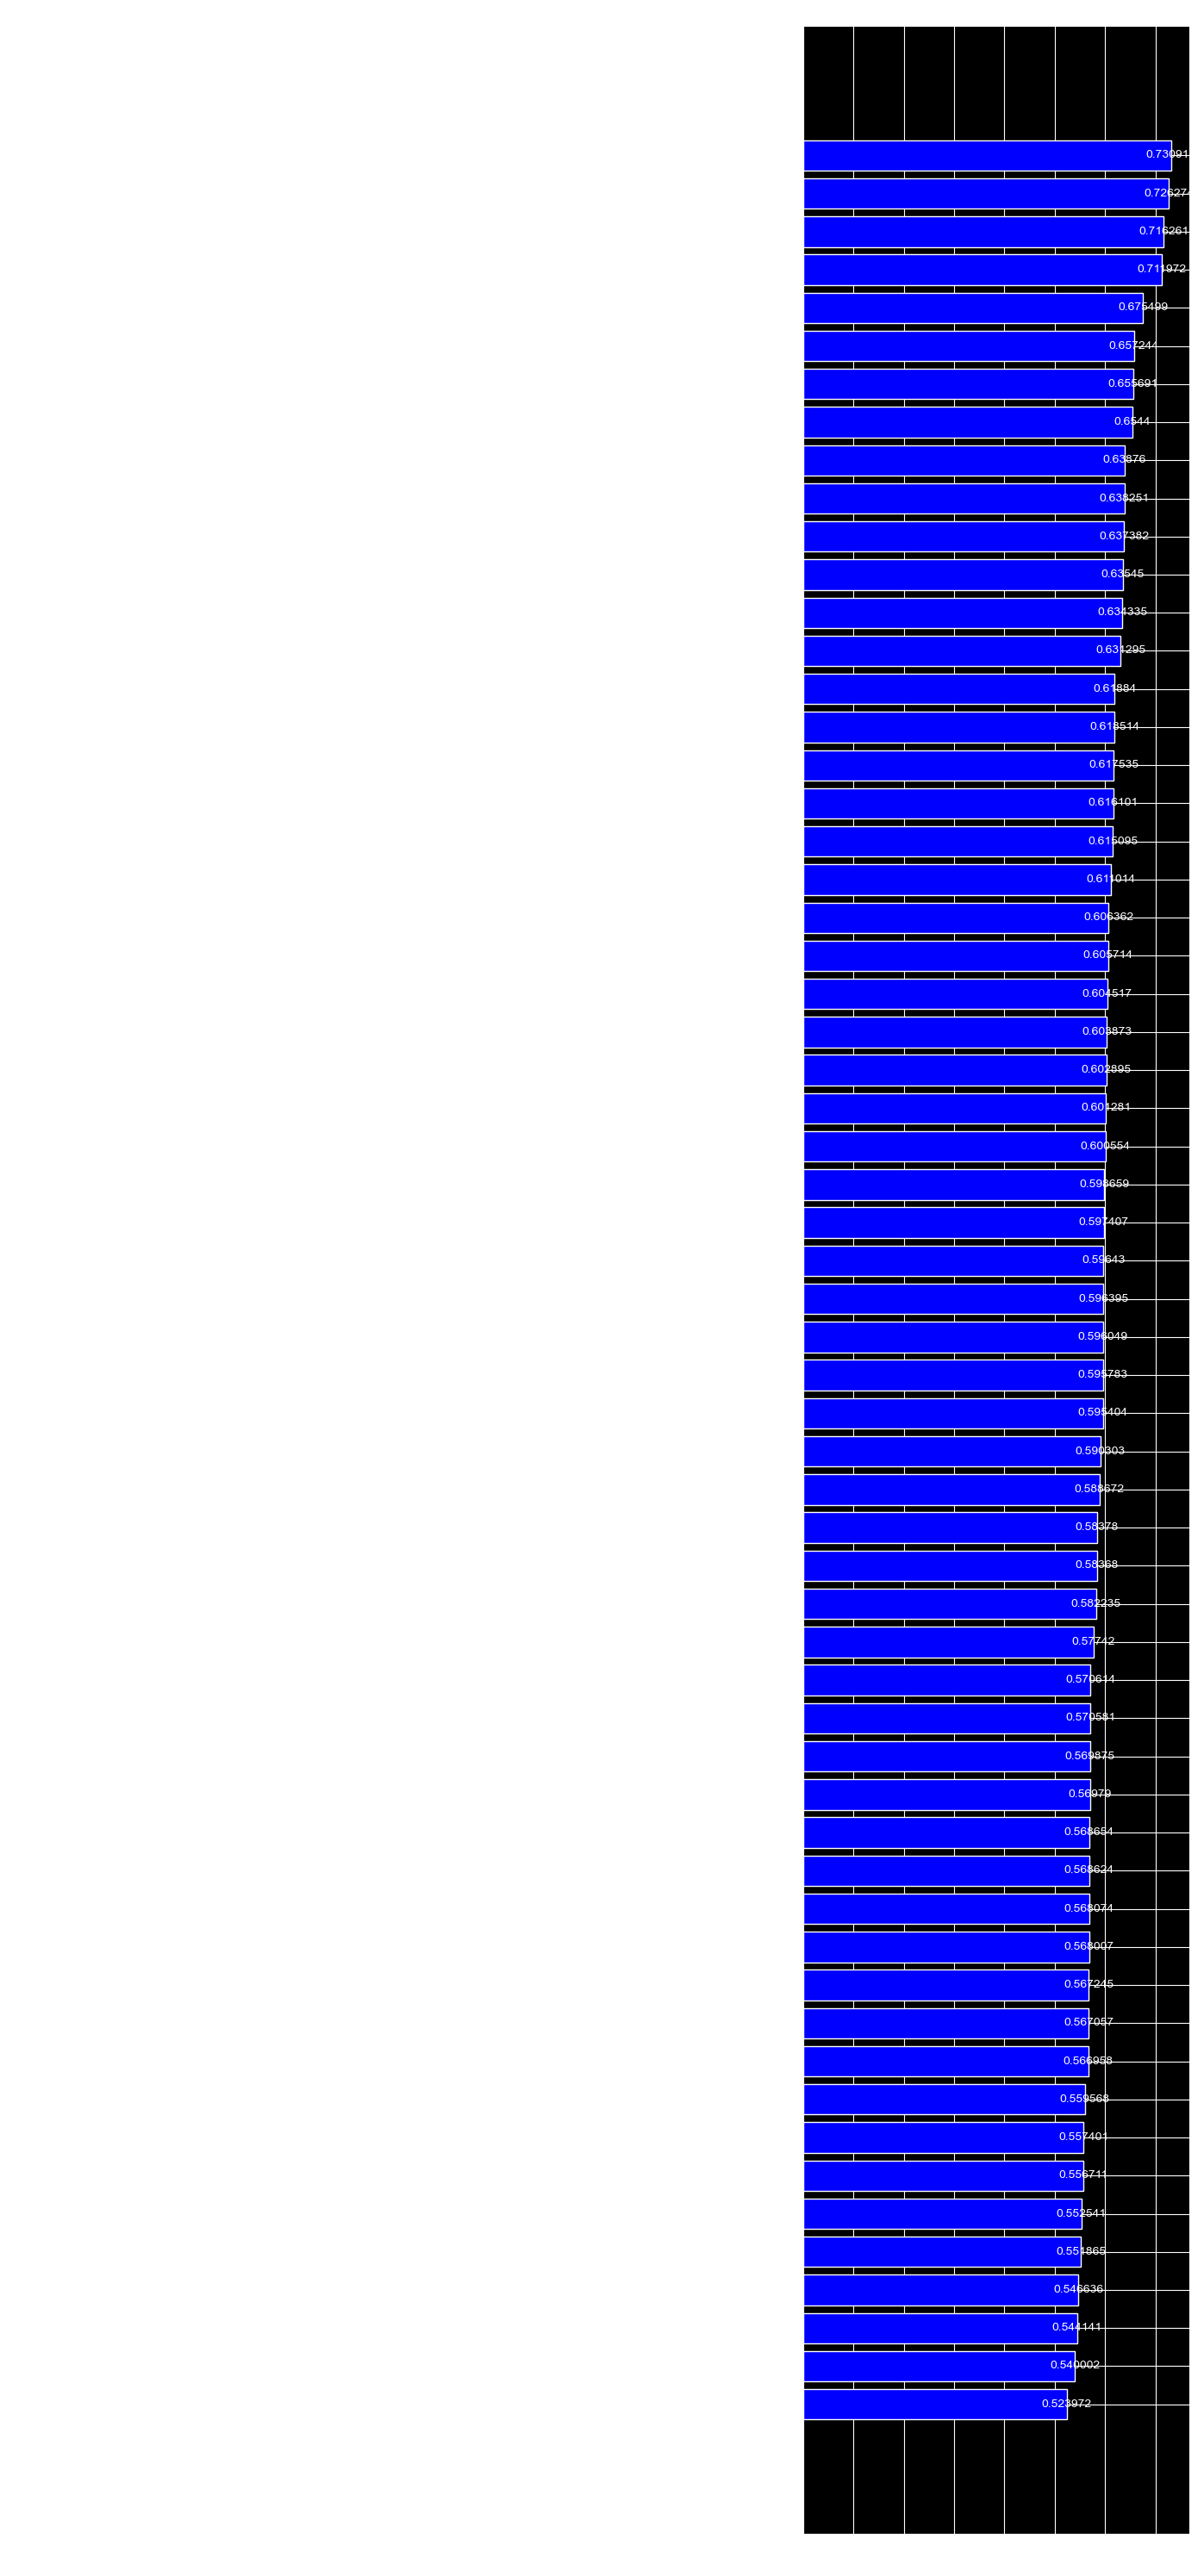

In [12]:
losses_pdf_path = os.path.join(root, f'{ROOT_NAME}_losses.pdf')

plot_bar_from_dict(losses, 'Model Losses', 'Name', 'Accuracy', losses_pdf_path)

Analysis part of model testing

In [13]:
model_categories = set(map(lambda name: '_'.join(name.split('_')[:-2]), model_names))
grouped_models = {key: list(filter(lambda name: name.startswith(key), model_names)) for key in model_categories}
keyed_accuracies = {key: [] for key in grouped_models}
keyed_losses = {key: [] for key in grouped_models}


def categorize_numbers(for_dict: dict[str, list[float]], numbers_dict: dict[str, float]) -> None:
    for group, value in for_dict.items():
        vals = [
            value for key, value in numbers_dict.items()
            if key.startswith(group)]

        value.extend(vals)


categorize_numbers(keyed_accuracies, accuracies)
categorize_numbers(keyed_losses, losses)

In [14]:
accuracies_from_models = pd.DataFrame(keyed_accuracies)
losses_from_models = pd.DataFrame(keyed_losses)

ValueError: All arrays must be of the same length

In [ ]:
accuracies_from_models.describe()

In [ ]:
ALPHA = .05
anova_testable_groups = []
kruskal_walis_testable_groups = []


def assign_models_to_groups(models: pd.DataFrame) -> None:
    for col in models.columns:
        _, p_value = shapiro(models[col])

        if p_value >= ALPHA:
            anova_testable_groups.append(col)
        else:
            kruskal_walis_testable_groups.append(col)


assign_models_to_groups(accuracies_from_models)

In [15]:
anova_values = []
kruskal_values = []
anova_cols = []

for col in anova_testable_groups:
    if col in accuracies_from_models:
        anova_values.append(accuracies_from_models[col].tolist())
        anova_cols.append(col)

for col in kruskal_walis_testable_groups:
    if col in accuracies_from_models:
        kruskal_values.append(accuracies_from_models[col].tolist())


f_stat_anova, p_value_anova = f_oneway(*anova_values)
h_stat_kruskal, p_value_kruskal = kruskal(*kruskal_values)

print(f'ANOVA p-value: {p_value_anova}')
print(f'Kruskal-Wallis p-value: {p_value_kruskal}')

NameError: name 'anova_testable_groups' is not defined

ANOVA p-value is extremely small, practically zero, which strongly indicates that there are significant differences between the means of the groups tested (those groups which passed the normality test). I reject the null hypothesis of equal means. Given this result, it's warranted to proceed to post-hoc analysis (like Tukey's HSD) to find out which specific groups have significantly different means.

Kruskal-Wallis p-value is relatively large (greater than common thresholds like 0.05 or 0.01), which suggests that I fail to reject the null hypothesis for the Kruskal-Wallis test. This indicates that there isn't a statistically significant difference between the median ranks of the groups tested (those groups which failed the normality test).

In [ ]:
tukey_vals = list(itertools.chain(*anova_values))
tukey_cols = []
idx = 0

for col in anova_values:
    n_repeat = len(col)
    group = [anova_cols[idx]] * n_repeat
    idx += 1

    tukey_cols.extend(group)

mc = MultiComparison(tukey_vals, tukey_cols)
tukeyhsd_result = mc.tukeyhsd()

with open(os.path.join('..', '..', 'debug_data', 'tukeyhsd.test'), 'w') as test_file:
    test_file.write(str(tukeyhsd_result))

Now Cohen-d values will be calculated for quantifying difference magnitudes between groups

In [ ]:
significant_pairs = np.column_stack((tukeyhsd_result.reject, tukeyhsd_result.reject2))
group_data = {}

for group, value in zip(tukey_cols, tukey_vals):
    if group not in group_data:
        group_data[group] = []

    group_data[group].append(value)


def cohen_d(group1, group2):
    diff = np.mean(group1) - np.mean(group2)
    pooled_var = ((len(group1) - 1) * np.var(group1, ddof=1) + (len(group2) - 1) * np.var(group2, ddof=1)) / (len(group1) + len(group2) - 2)
    d_val = diff / np.sqrt(pooled_var)

    return d_val


group_indices = range(len(tukeyhsd_result.groupsunique))
all_pairs = list(combinations(group_indices, 2))
significant_pairs_idx = np.where(tukeyhsd_result.reject)[0]

for pair_idx in significant_pairs_idx:
    i, j = all_pairs[pair_idx]
    d = cohen_d(group_data[tukeyhsd_result.groupsunique[i]], group_data[tukeyhsd_result.groupsunique[j]])
    print(f"Cohen's d for {tukeyhsd_result.groupsunique[i]} and {tukeyhsd_result.groupsunique[j]}: {d}")


In [ ]:
group_stats = {group: (np.mean(values), np.std(values)) for group, values in group_data.items()}

for group, (mean, std) in group_stats.items():
    print(f"{group}: Mean = {mean:.2f}, Std = {std:.2f}")

sns.boxplot(x=tukey_cols, y=tukey_vals)
plt.xticks(rotation=90)
plt.show()

In conclusion:

1. ANOVA and Kruskal-Wallis tests have shown that there are statistically significant differences between the models performances, which is confirmed by the boxplots interpretation. A null hypothesis of all the groups having the same mean could have been rejected.
2. Cohen-d values for the best performing models, that is:
    - 3_whole_model_trainable_with_attention_module_on_top
    - 4_only_bottom_half_layers_trainable_with_attention_module_on_top
    - 2_only_bottom_half_layers_trainable
   have shown that magnitudes of the differences of those models are statistically insignificant.
3. At the same time those are the 3 best performing models. Visual inspection shows that the whiskers of the 3_whole_model_trainable_with_attention_module_on_top and 2_only_bottom_half_layers_trainable plots are longer than those of 3_whole_model_trainable_with_attention_module_on_top. That means that the two models are more prone to produce more spread out results, while the 3_whole_model_trainable_with_attention_module_on_top produces more consistent results.
4. From the above it can be concluded that either the 3_whole_model_trainable_with_attention_module_on_top model or 4_only_bottom_half_layers_trainable_with_attention_module_on_top are the best ones.

Now let's pick the best model instance to see the confusion matrix for best model.

In [ ]:
name = ''
best_acc = 0

for key, value in accuracies.items():
    if '3_whole_model_trainable_with_attention_module_on_top' in key and value > best_acc:
        name = key
        best_acc = value

model_path = os.path.join(models_dir, name)
model = keras.models.load_model(model_path)
y_pred_labels = model.predict(test_ds)

              precision    recall  f1-score   support

       akiec       0.03      0.03      0.03        65
         bcc       0.04      0.05      0.05       102
         bkl       0.10      0.12      0.11       219
          df       0.00      0.00      0.00        23
         mel       0.11      0.09      0.10       222
          nv       0.67      0.67      0.67      1341
        vasc       0.04      0.04      0.04        28

    accuracy                           0.48      2000
   macro avg       0.14      0.14      0.14      2000
weighted avg       0.47      0.48      0.48      2000



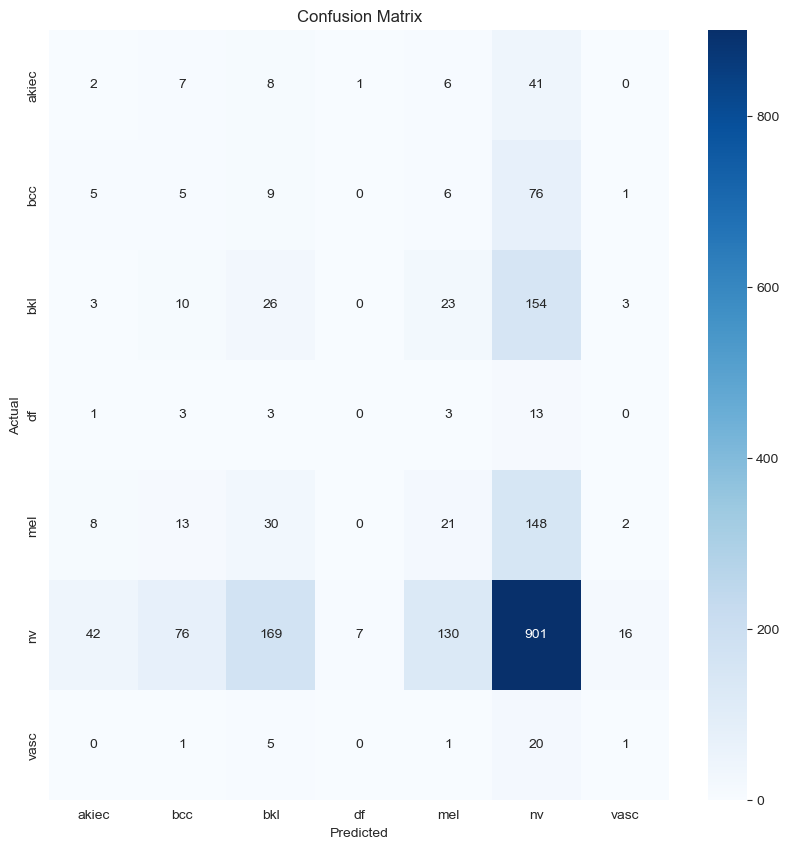

In [35]:
y_test = []

for _, labels in test_ds:
    y_test.extend(np.argmax(labels.numpy(), axis=-1))

y_test = np.array(y_test)
report = classification_report(y_test, y_pred_labels, target_names=test_ds.class_names, zero_division=0)
print(report)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

It's very visible that the model despite having over 81% accuracy, still gets confused a lot by the classes that are not often encountered in the dataset.